# State Farm Distracted Driver Detection

## Libraries

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

## 0. Load Data

In [2]:
img_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'

df = pd.read_csv('/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
df.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


## 1. Data Exploration & Preparation

### Exploratory Data Analysis
* Understand data through visualization
* Analyze class distrubution and possible class imbalance
* Inspect image quality

#### 1.0 Data Visualization
Look through samples of the data

In [3]:
s = df.groupby('classname').sample(n=1)

In [4]:
imgs = pd.DataFrame(s, columns=['classname', 'img'])
imgs.reset_index(inplace=True, drop=True)
imgs

,classname,img
0,c0,img_63842.jpg
1,c1,img_45998.jpg
2,c2,img_39438.jpg
3,c3,img_37425.jpg
4,c4,img_93664.jpg
5,c5,img_43081.jpg
6,c6,img_49065.jpg
7,c7,img_6787.jpg
8,c8,img_94386.jpg
9,c9,img_99740.jpg


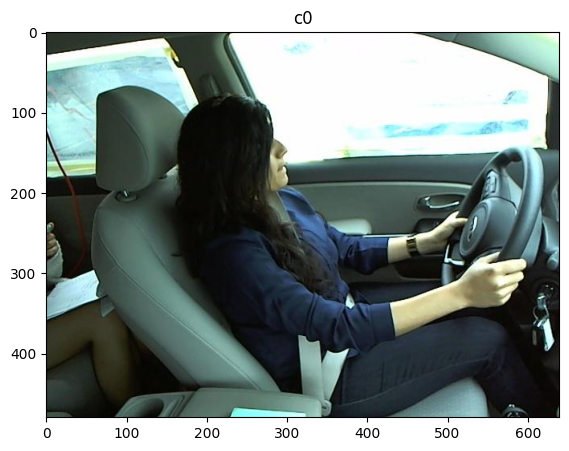

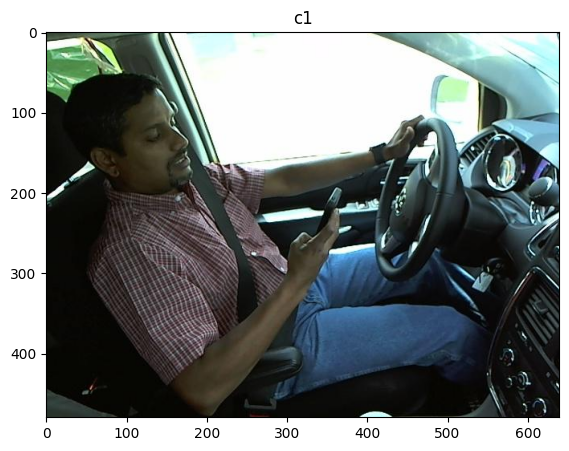

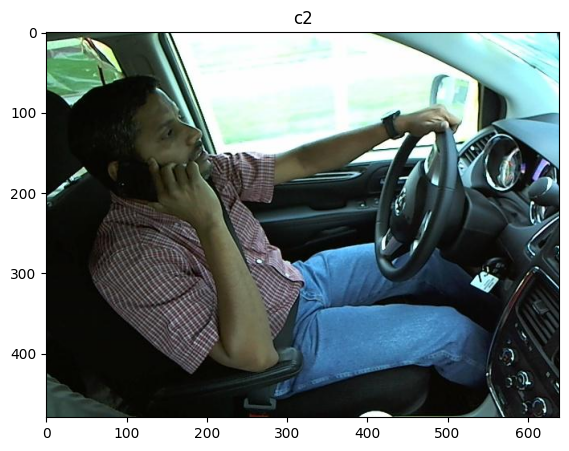

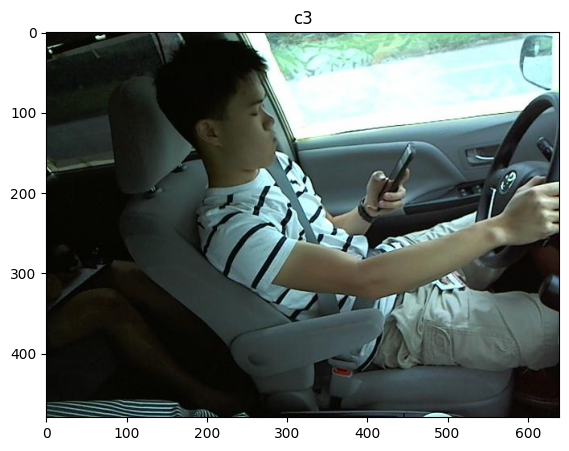

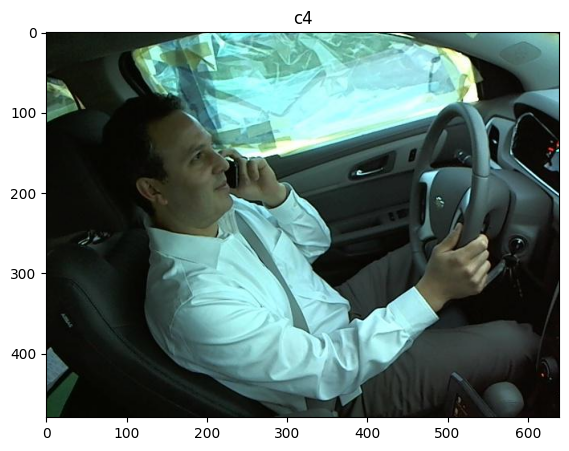

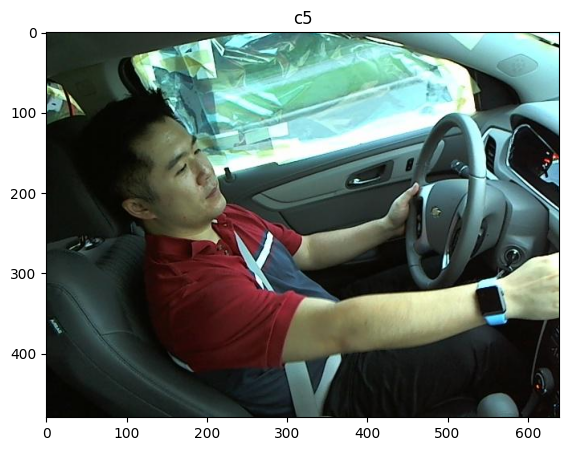

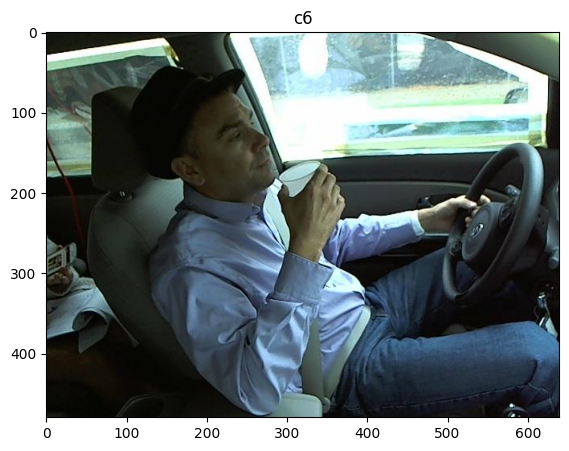

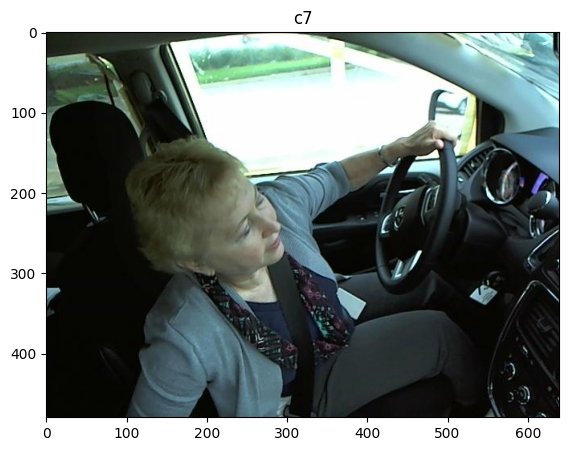

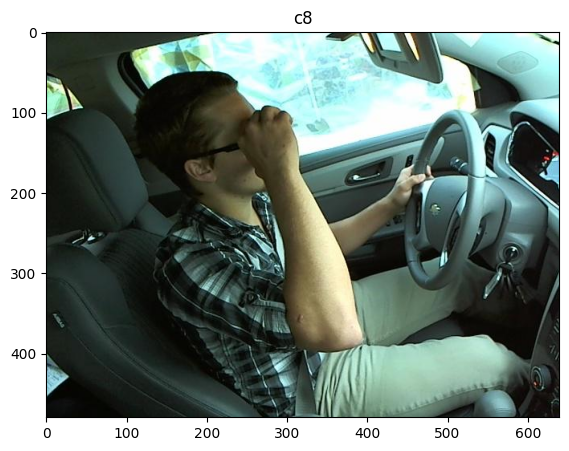

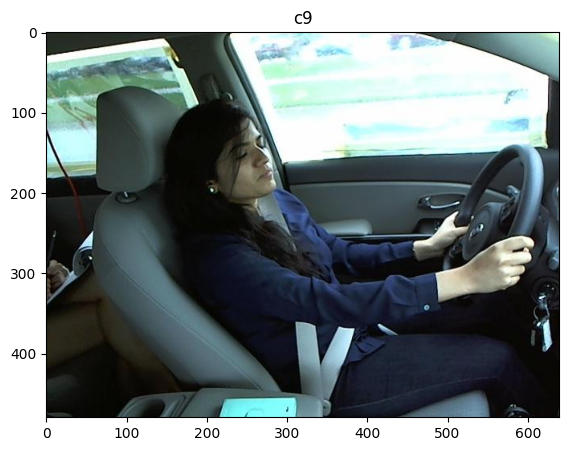

In [5]:
for i in range(10):
    img_l= os.path.join(img_dir, imgs['classname'][i], imgs['img'][i])
    img = mpimg.imread(img_l)
    plt.figure(figsize=(9, 5))
    plt.imshow(img)
    plt.title(imgs['classname'][i])
    plt.show()

Photo quality seems good enough.
- All images are at an angle facing the driver
- Some photos include a slight view of the backseat passenger, while others only show the driver.

#### 1.1 Class Distribution
* Understand the distribution of columns in the data set.
* Find the distribution of every column (subject, classname, img)

#### Subject Distribution

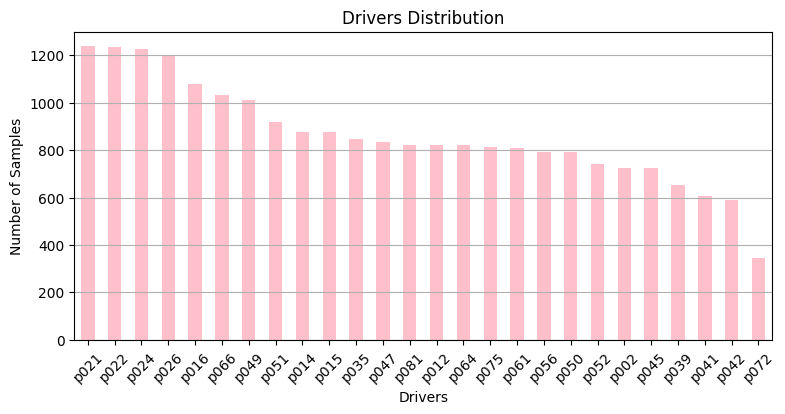

In [6]:
# Count the number of occurrences of each class
class_counts = df['subject'].value_counts()

# Plot the distribution
plt.figure(figsize=(9, 4))
class_counts.plot(kind='bar', color='pink')
plt.title('Drivers Distribution')
plt.xlabel('Drivers')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#### Classname Distribution

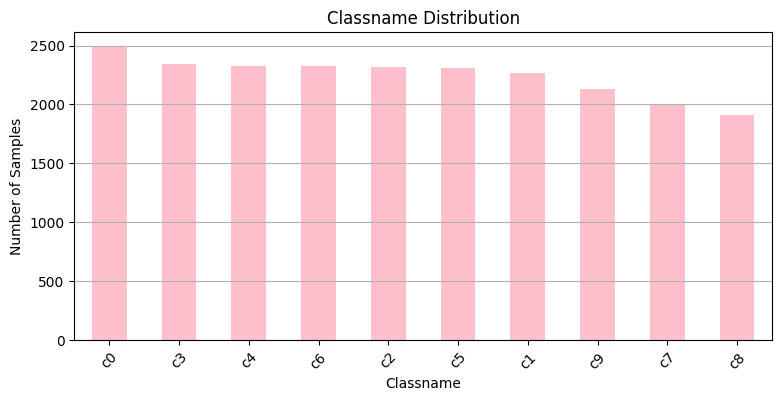

In [7]:
# Count the number of occurrences of each class
class_counts = df['classname'].value_counts()

# Plot the distribution
plt.figure(figsize=(9, 4))
class_counts.plot(kind='bar', color='pink')
plt.title('Classname Distribution')
plt.xlabel('Classname')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#### Img Distribution
Ensure that there are no duplicate images. To visualize it may take quite a long time since img is likely to be unique.
So, instead of render every single bar, we can instead see if every of them are unique.

In [8]:
# Check the total number of 'img' entries
total_entries = len(df['img'])

# Check the number of unique 'img' entries
unique_entries = df['img'].nunique()

# Print the results
print(f"Total number of image entries: {total_entries}")
print(f"Number of unique image entries: {unique_entries}")

# Check if every image entry is unique
if total_entries == unique_entries:
    print("Every image entry is unique.")
else:
    print(f"There are {total_entries - unique_entries} duplicate image entries.")

Total number of image entries: 22424
Number of unique image entries: 22424
Every image entry is unique.


***Before the below items (1.2, 1.3, 1.4), it will better to check what kind of inputs each model want. May be some model don't need to resize the image, simplify the color, etc.***

### 1.2 Image Quality Check
Check if all images are of consistent
1. quality
2. resolution
3. orientation

Identify any corrupted or unreadable images.

**Note**: Based on the suggestion from James, since those image are already labeled, they are very likely to be okay, such the as the resolution, orientation, and the size.

1. write the code to check integrity for easy items, such as
  a. if every single img has the same size
  b. resolution same for each img? (how many pixels are displayed per inch of an image)
2. Manually random choose a portion of images (may be quickly galance 1000 images?), to build confidence:
  a. same orientation?
  b. any corrupted data?

In [9]:
df.drop(columns='subject', inplace= True)
df

,classname,img
0,c0,img_44733.jpg
1,c0,img_72999.jpg
2,c0,img_25094.jpg
3,c0,img_69092.jpg
4,c0,img_92629.jpg
...,...,...
22419,c9,img_56936.jpg
22420,c9,img_46218.jpg
22421,c9,img_25946.jpg
22422,c9,img_67850.jpg


In [10]:
# create list of images
imgs = []
for i in range(len(df)):
    img_l= os.path.join(img_dir, df['classname'][i], df['img'][i])
    img = cv.imread(img_l)
    
    imgs.append(img)

#### Resolution
Ensure all images are the same size

In [11]:
width = 640
height = 480

resolution_check = all(img.shape[0] == height and img.shape[1] == width for img in imgs)

if resolution_check == True:
    print('All images are the same resolution')
else:
    print('All images are not the same resolution')

All images are the same resolution


All images are the same size and do not need resizing

### 1.4 Data Augmentation?
GPT4:  Given the nature of the challenge (distracted driving), augmenting the dataset with rotations, shifts, flips, etc., can be beneficial to make the model robust. Are there some preprocess needed to make the training more efficient?

Note: Based on suggestions from James, there are already many advanced CV libraries handled those.

Action: Skip here for now. If any of the model we gonna use requires a specific input format, then revise here. Though, it's not likely be the case.

Assignee: No needed

# 1.5 Splitting the Data
Note: Images are already spliited into train and test folder, but we are only given one input csv. So here is where we need to split the csv into two parts. We need two data frames.

### Training and Validation Set

In [12]:
train_data = tf.keras.utils.image_dataset_from_directory(img_dir, subset='training', validation_split=0.2, label_mode='categorical', seed=13)
val_data = tf.keras.utils.image_dataset_from_directory(img_dir, subset='validation', validation_split=0.2, label_mode='categorical', seed=13)

Found 22424 files belonging to 10 classes.
Using 17940 files for training.
Found 22424 files belonging to 10 classes.
Using 4484 files for validation.


### Testing Set

In [13]:
test_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs/test'
train_data = tf.keras.utils.image_dataset_from_directory(test_dir, labels=None, label_mode=None, seed=13)

Found 79726 files belonging to 1 classes.


## 2. Model Selection / Experiments
We are quite new to this area, so let's do some experiments. James have provided some links he found seems to be helpful.

Resources:
> 1. Tenserflow has a lot of interesting examples here.
https://www.tensorflow.org/lite/examples
One that might be useful for you guys is this gesture recognition one
https://github.com/tensorflow/examples/tree/master/lite/examples/gesture_classification/android

> 2. Also check out the section here on using Google’s TeachableMachines
https://github.com/jfd235/Interactive-Lab-Hub/tree/Fall2022/Lab%205

> 3. These articles seem to point to repositories that already have code in Colab/Jupyter notebook form
https://towardsdatascience.com/tutorial-using-deep-learning-and-cnns-to-make-a-hand-gesture-recognition-model-371770b63a51
https://developers.google.com/mediapipe/solutions/customization/gesture_recognizer

Final Note from James:
> There are a ton of resources out there like this, so I’d pick one that looks easy (the TeachableMachines looks really easy to prototype with IMO), try it with a few of your images for training (no point in using all of them since we’re just testing things for now), and see if they can predict a few of your other images for testing

### 2.1 Experiements Report for those sources
Don't have to be only one assignee.
Assignee: